# Assignment 5 - Visualizing Data Veracity Challenges in Multi-Label Classification

In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
# Data Loading
from scipy.io import arff

## Part A: Preprocessing and Initial Setup

In [52]:
# Load the yeast dataset
data, meta = arff.loadarff('dataset/yeast.arff')

# Convert to pandas DataFrame
df = pd.DataFrame(data)

# Get column names
columns = df.columns.tolist()

# Find where features end and labels begin
# Features are named 'Att1', 'Att2', etc.
# Labels are named 'Class1', 'Class2', etc.
feature_cols = [col for col in columns if col.startswith('Att')]
label_cols = [col for col in columns if col.startswith('Class')]

print(f"Feature columns: {len(feature_cols)} (from {feature_cols[0]} to {feature_cols[-1]})")
print(f"Label columns: {len(label_cols)} (from {label_cols[0]} to {label_cols[-1]})")

# Separate features (X) and labels (Y)
X = df[feature_cols].astype(float)
Y = df[label_cols].astype(int)

# Print dimensions
print(f"Features (X) shape: {X.shape}")
print(f"Labels (Y) shape: {Y.shape}")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of labels: {Y.shape[1]}")

Feature columns: 103 (from Att1 to Att103)
Label columns: 14 (from Class1 to Class14)
Features (X) shape: (2417, 103)
Labels (Y) shape: (2417, 14)
Number of samples: 2417
Number of features: 103
Number of labels: 14


In [53]:
# Label Selection for visualization

# Create label combinations as strings for easier analysis
Y_combinations = Y.apply(lambda row: ''.join(row.astype(str)), axis=1)

# Count frequency of each label combination
combination_counts = Y_combinations.value_counts()
print("Top 10 frequent label combinations:")
print(combination_counts.head(10))
print()

# Find single-label classes (combinations with exactly one '1')
single_label_mask = Y.sum(axis=1) == 1
single_label_combinations = Y_combinations[single_label_mask]
single_label_counts = single_label_combinations.value_counts()

print("Most frequent single-label classes:")
print(single_label_counts.head())
print()

# Find multi-label classes (combinations with more than one '1')
multi_label_mask = Y.sum(axis=1) > 1
multi_label_combinations = Y_combinations[multi_label_mask]
multi_label_counts = multi_label_combinations.value_counts()

print("Most frequent multi-label combinations:")
print(multi_label_counts.head(5))
print()

# Get the two most frequent single-label classes
top_single_labels = single_label_counts.head(5).index.tolist()
print(f"Top 2 single-label classes: {top_single_labels}")

# Get the most frequent multi-label combination
top_multi_label = multi_label_counts.index[0] if len(multi_label_counts) > 0 else None
print(f"Top multi-label combination: {top_multi_label}")
print()

# Create visualization target variable
visualization_target = []

for combination in Y_combinations:
    if combination in top_single_labels:
        # Find which single label this is
        if combination == top_single_labels[0]:
            visualization_target.append(f"Single-1: {combination}")
        else:
            visualization_target.append(f"Single-2: {combination}")
    elif combination == top_multi_label:
        visualization_target.append(f"Multi: {combination}")
    else:
        visualization_target.append("Other")

# Convert to pandas Series
visualization_target = pd.Series(visualization_target)

# Display the distribution of the new target variable
print("Distribution of visualization target variable:")
print(visualization_target.value_counts())
print()
print(f"Total samples: {len(visualization_target)}")

Top 10 frequent label combinations:
00110000000110    237
00011000000110    233
11000000000110    172
11000000000000    131
01100000000110    117
00001100000110    105
00000011000110     75
01100000000000     68
00001111000110     60
10000000000110     59
Name: count, dtype: int64

Most frequent single-label classes:
10000000000000    32
Name: count, dtype: int64

Most frequent multi-label combinations:
00110000000110    237
00011000000110    233
11000000000110    172
11000000000000    131
01100000000110    117
Name: count, dtype: int64

Top 2 single-label classes: ['10000000000000']
Top multi-label combination: 00110000000110

Distribution of visualization target variable:
Other                       2148
Multi: 00110000000110        237
Single-1: 10000000000000      32
Name: count, dtype: int64

Total samples: 2417


### Why Scaling is Crucial for Distance-Based Dimensionality Reduction

Scaling is essential before applying distance-based dimensionality reduction techniques for several key reasons:

1. **Feature Scale Differences**: Features may have vastly different scales (e.g., one feature ranges 0-1, another 0-1000). Without scaling, features with larger scales will dominate distance calculations.

2. **Distance Metric Sensitivity**: Techniques like PCA, t-SNE, and UMAP rely on Euclidean distances. Large-scale features will disproportionately influence these distances, leading to biased results.

3. **Variance Preservation**: PCA identifies directions of maximum variance. If features have different scales, the algorithm will prioritize high-variance features due to their scale, not their actual information content.

4. **Optimization Convergence**: Many dimensionality reduction algorithms use gradient-based optimization. Unscaled features can cause slow convergence or poor local minima.

5. **Interpretability**: Scaled features ensure that each dimension contributes equally to the analysis, making results more interpretable and fair across all features.

In [54]:
# Feature Scaling - Standardization

# Check feature statistics before scaling
print("Feature statistics before scaling:")
print(f"Feature means range: {X.mean().min():.6f} to {X.mean().max():.6f}")
print(f"Feature std range: {X.std().min():.6f} to {X.std().max():.6f}")
print(f"Feature min values range: {X.min().min():.6f} to {X.min().max():.6f}")
print(f"Feature max values range: {X.max().min():.6f} to {X.max().max():.6f}")
print()

# Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for easier handling
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Check feature statistics after scaling
print("Feature statistics after scaling:")
print(f"Feature means range: {X_scaled.mean().min():.6f} to {X_scaled.mean().max():.6f}")
print(f"Feature std range: {X_scaled.std().min():.6f} to {X_scaled.std().max():.6f}")
print(f"Feature min values range: {X_scaled.min().min():.6f} to {X_scaled.min().max():.6f}")
print(f"Feature max values range: {X_scaled.max().min():.6f} to {X_scaled.max().max():.6f}")
print()

print(f"Original X shape: {X.shape}")
print(f"Scaled X shape: {X_scaled.shape}")

Feature statistics before scaling:
Feature means range: -0.002414 to 0.007605
Feature std range: 0.092333 to 0.105738
Feature min values range: -0.797436 to -0.158874
Feature max values range: 0.163431 to 0.729621

Feature statistics after scaling:
Feature means range: -0.000000 to 0.000000
Feature std range: 1.000207 to 1.000207
Feature min values range: -8.128474 to -1.622550
Feature max values range: 1.568501 to 7.516607

Original X shape: (2417, 103)
Scaled X shape: (2417, 103)


## Part B: t-SNE and Veracity Inspection

In [55]:
# t-SNE Implementation with different perplexity values
from sklearn.manifold import TSNE

# Define 9 perplexity values to experiment with
perplexity_values = [5, 10, 15, 20, 25, 30, 35, 40, 50]

# Dictionary to store t-SNE results
tsne_results = {}

print("Applying t-SNE with 9 different perplexity values...")
print("Note: This will take some time as we're computing 9 different embeddings")
print()

for i, perp in enumerate(perplexity_values):
    print(f"Computing t-SNE {i+1}/9 with perplexity={perp}...")
    
    # Apply t-SNE
    tsne = TSNE(
        n_components=2,
        perplexity=perp,
        random_state=42,
        max_iter=1000,
        learning_rate='auto',
        init='random'
    )
    
    # Fit and transform the scaled data
    tsne_embedding = tsne.fit_transform(X_scaled)
    
    # Store results
    tsne_results[perp] = {
        'embedding': tsne_embedding,
        'kl_divergence': tsne.kl_divergence_
    }
    
    print(f"  Completed! Final KL divergence: {tsne.kl_divergence_:.4f}")

print("\nt-SNE computation completed for all perplexity values!")
print()

# Display the shapes and basic statistics
for perp in perplexity_values:
    embedding = tsne_results[perp]['embedding']
    print(f"Perplexity {perp}:")
    print(f"  Embedding shape: {embedding.shape}")
    print(f"  X-axis range: [{embedding[:, 0].min():.2f}, {embedding[:, 0].max():.2f}]")
    print(f"  Y-axis range: [{embedding[:, 1].min():.2f}, {embedding[:, 1].max():.2f}]")
    print(f"  KL divergence: {tsne_results[perp]['kl_divergence']:.4f}")
    print()

Applying t-SNE with 9 different perplexity values...
Note: This will take some time as we're computing 9 different embeddings

Computing t-SNE 1/9 with perplexity=5...
  Completed! Final KL divergence: 2.0496
Computing t-SNE 2/9 with perplexity=10...
  Completed! Final KL divergence: 2.0496
Computing t-SNE 2/9 with perplexity=10...
  Completed! Final KL divergence: 2.2734
Computing t-SNE 3/9 with perplexity=15...
  Completed! Final KL divergence: 2.2734
Computing t-SNE 3/9 with perplexity=15...
  Completed! Final KL divergence: 2.2430
Computing t-SNE 4/9 with perplexity=20...
  Completed! Final KL divergence: 2.2430
Computing t-SNE 4/9 with perplexity=20...
  Completed! Final KL divergence: 2.2389
Computing t-SNE 5/9 with perplexity=25...
  Completed! Final KL divergence: 2.2389
Computing t-SNE 5/9 with perplexity=25...
  Completed! Final KL divergence: 2.2271
Computing t-SNE 6/9 with perplexity=30...
  Completed! Final KL divergence: 2.2271
Computing t-SNE 6/9 with perplexity=30...
  

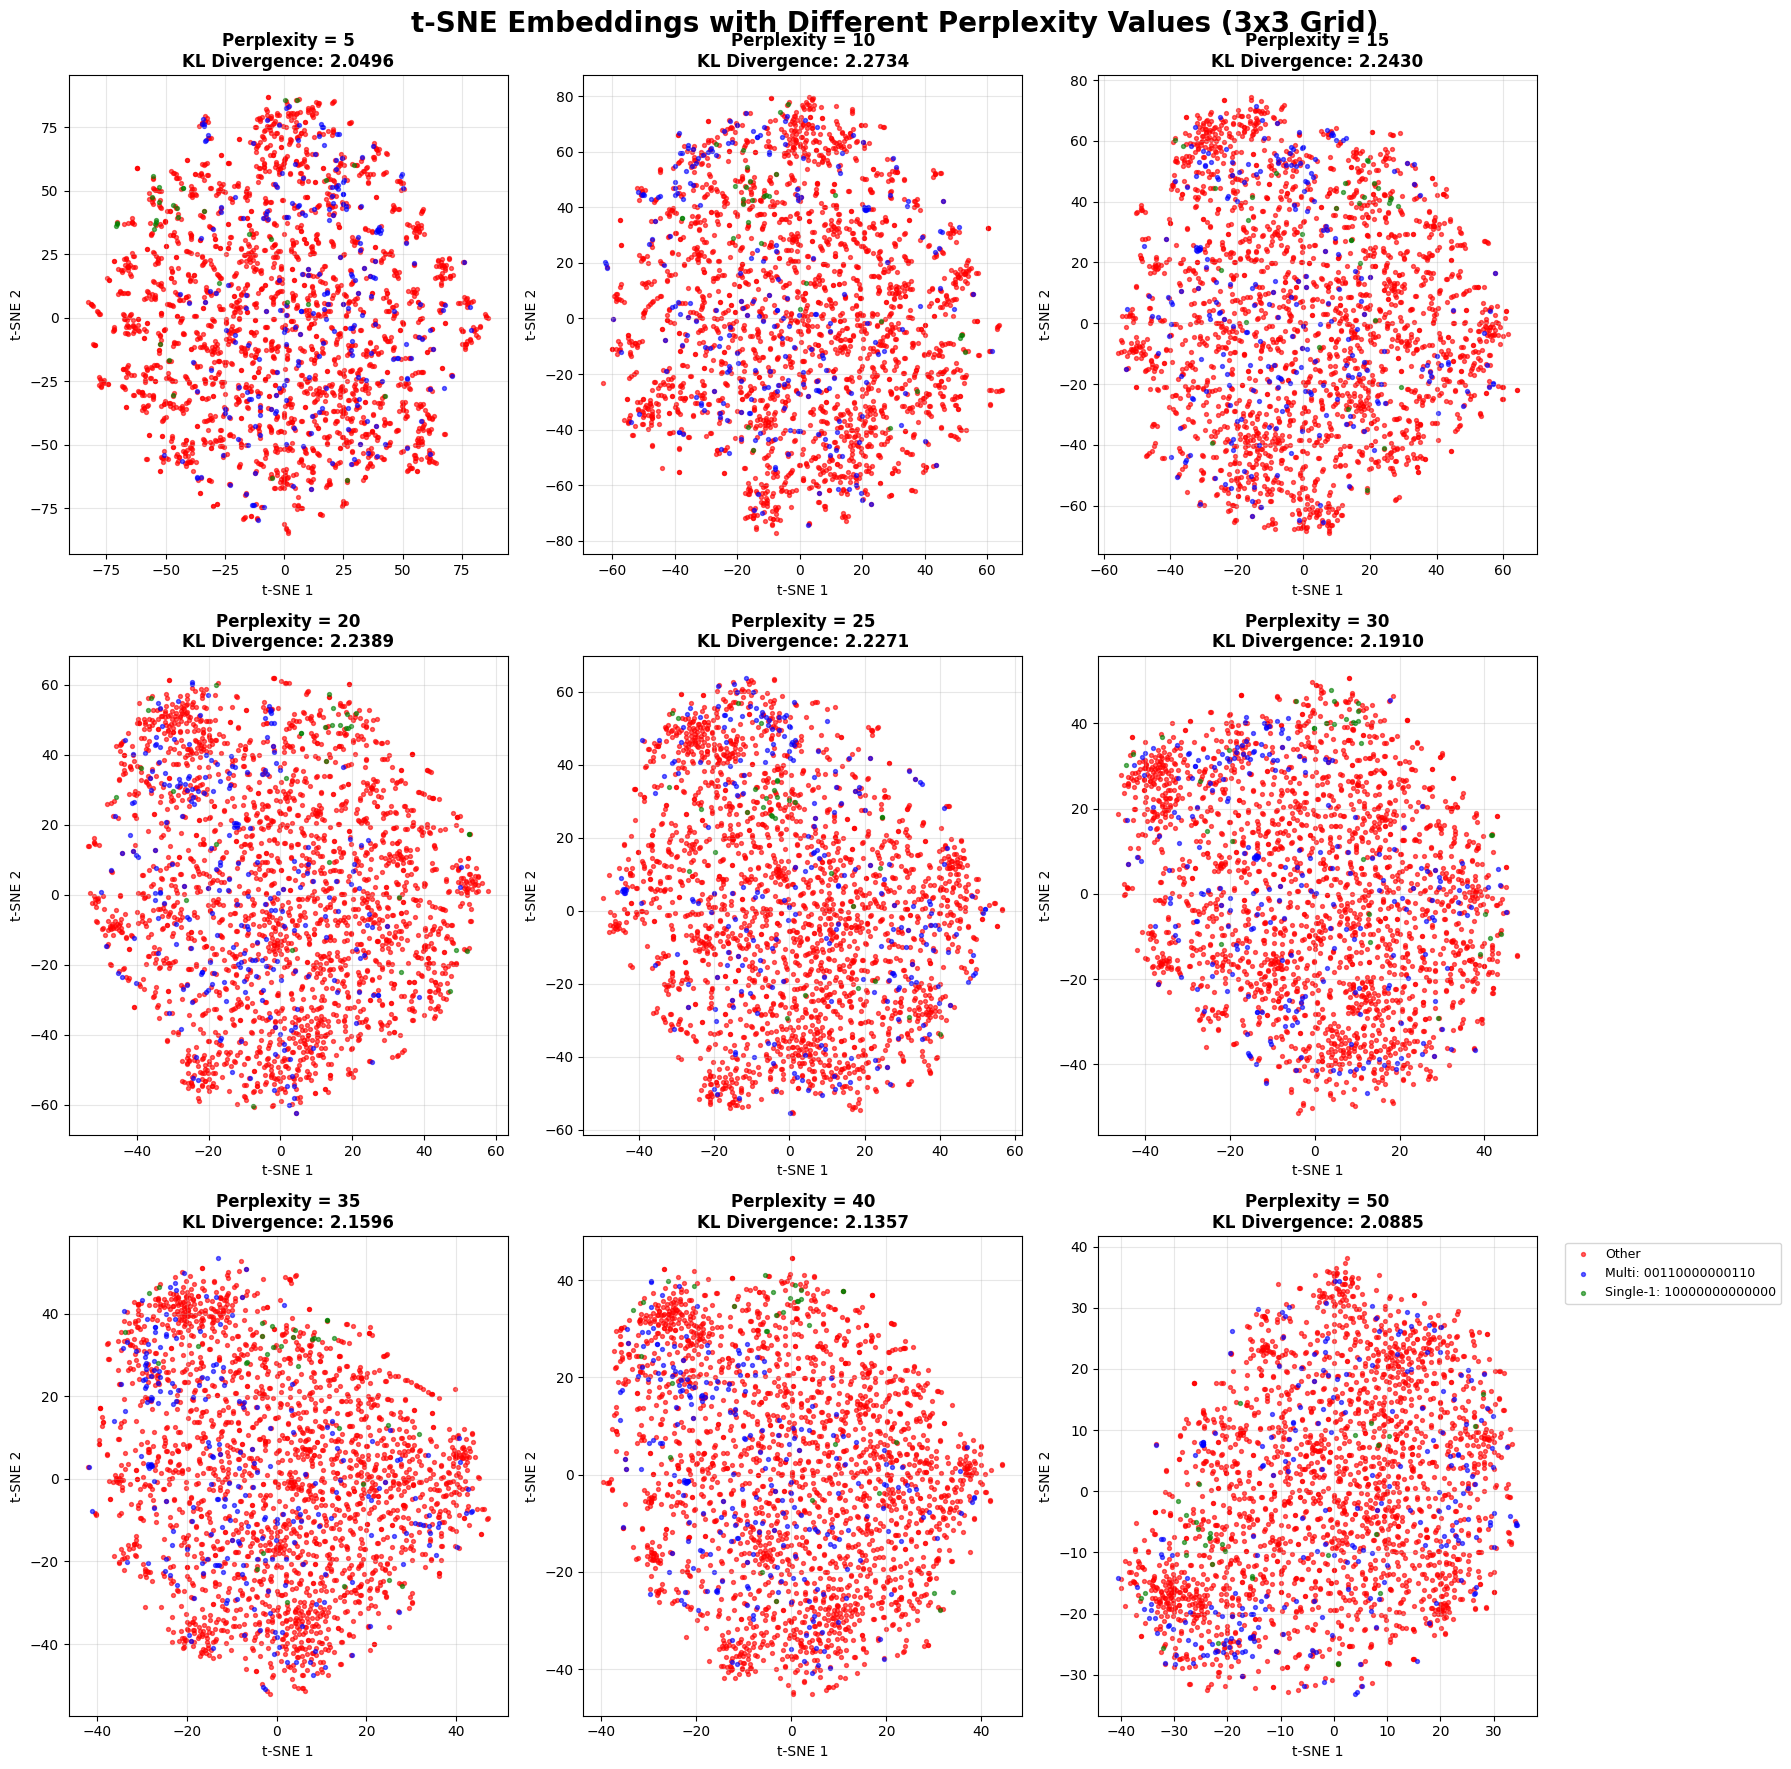

Detailed Analysis of Perplexity Effects on t-SNE Visualization:

KL Divergence Comparison (Lower is Better):
   1. Perplexity   5: 2.0496
   2. Perplexity  50: 2.0885
   3. Perplexity  40: 2.1357
   4. Perplexity  35: 2.1596
   5. Perplexity  30: 2.1910
   6. Perplexity  25: 2.2271
   7. Perplexity  20: 2.2389
   8. Perplexity  15: 2.2430
   9. Perplexity  10: 2.2734


In [56]:
# Visualize t-SNE results with different perplexity values in a 3x3 grid

# Create a 3x3 figure with subplots for each perplexity value
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
fig.suptitle('t-SNE Embeddings with Different Perplexity Values (3x3 Grid)', fontsize=20, fontweight='bold')

colors = ['red', 'blue', 'green', 'orange']
color_map = {cat: colors[i] for i, cat in enumerate(visualization_target.unique())}

# Flatten axes for easier indexing
axes_flat = axes.flatten()

for idx, perp in enumerate(perplexity_values):
    embedding = tsne_results[perp]['embedding']
    kl_div = tsne_results[perp]['kl_divergence']
    
    # Get the current subplot
    ax = axes_flat[idx]
    
    # Create scatter plot for each category
    for category in visualization_target.unique():
        mask = visualization_target == category
        ax.scatter(
            embedding[mask, 0], 
            embedding[mask, 1],
            c=color_map[category],
            label=category,
            alpha=0.6,
            s=8
        )
    
    ax.set_title(f'Perplexity = {perp}\nKL Divergence: {kl_div:.4f}', fontweight='bold', fontsize=12)
    ax.set_xlabel('t-SNE 1', fontsize=10)
    ax.set_ylabel('t-SNE 2', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add legend only to the last subplot (bottom right)
    if idx == len(perplexity_values) - 1:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

# Print detailed analysis of perplexity effects
print("Detailed Analysis of Perplexity Effects on t-SNE Visualization:")
print("=" * 80)
print()

# Group perplexity values for analysis
low_perp = [p for p in perplexity_values if p <= 15]
med_perp = [p for p in perplexity_values if 20 <= p <= 40]
high_perp = [p for p in perplexity_values if p >= 50]

print("KL Divergence Comparison (Lower is Better):")
sorted_results = sorted([(perp, tsne_results[perp]['kl_divergence']) for perp in perplexity_values], 
                        key=lambda x: x[1])

for i, (perp, kl_div) in enumerate(sorted_results):
    rank = i + 1
    print(f"  {rank:2d}. Perplexity {perp:3d}: {kl_div:.4f}")

best_perp = sorted_results[0][0]

### Perplexity in t-SNE

**Definition:**  
Perplexity is a smooth measure of the effective number of neighbors each point considers:

Perplexity(P<sub>i</sub>) = 2<sup>H(P<sub>i</sub>)</sup>

where H(P<sub>i</sub>) is the Shannon entropy of the conditional probability distribution of neighbors around point i.

**How it works:**  
t-SNE builds neighbor probabilities with Gaussians; perplexity sets the target entropy, controlling Gaussian width.

**Interpretation (analogy):**  
- Low (5–15): local — like listening to a few close friends.  
- High (30–50): global — like listening to a bigger crowd.
